# Imports and Data Wrangling

In [ ]:
! pip install -q kaggle

### Upload your kaggle key

Instructions to get your key:
**Authentication**
In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nathanparikh","key":"2de3c8dcc81b6aa0dd71c41013bdd161"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans


covid19-ct-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


## Unzip the data

In [ ]:
! unzip covid19-ct-scans.zip

Archive:  covid19-ct-scans.zip
replace ct_scans/coronacases_org_001.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ct_scans/coronacases_org_001.nii  
  inflating: ct_scans/coronacases_org_002.nii  
  inflating: ct_scans/coronacases_org_003.nii  
  inflating: ct_scans/coronacases_org_004.nii  
  inflating: ct_scans/coronacases_org_005.nii  
  inflating: ct_scans/coronacases_org_006.nii  
  inflating: ct_scans/coronacases_org_007.nii  
  inflating: ct_scans/coronacases_org_008.nii  
  inflating: ct_scans/coronacases_org_009.nii  
  inflating: ct_scans/coronacases_org_010.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii  
  inflating: ct_s

In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
# Read and examine metadata
data = pd.read_csv('metadata.csv')
data['ct_scan'] = data['ct_scan'].str[26:]
data['lung_mask'] = data['lung_mask'].str[26:]
data['infection_mask'] = data['infection_mask'].str[26:]
data['lung_and_infection_mask'] = data['lung_and_infection_mask'].str[26:]

data.sample(2)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
1,ct_scans/coronacases_org_002.nii,lung_mask/coronacases_002.nii,infection_mask/coronacases_002.nii,lung_and_infection_mask/coronacases_002.nii
19,ct_scans/radiopaedia_org_covid-19-pneumonia-7_...,lung_mask/radiopaedia_7_85703_0.nii,infection_mask/radiopaedia_7_85703_0.nii,lung_and_infection_mask/radiopaedia_7_85703_0.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

# Sample Data

In [ ]:
# Read sample
sample_ct   = read_nii(data.loc[1,'ct_scan'])
sample_lung = read_nii(data.loc[1,'lung_mask'])
sample_infe = read_nii(data.loc[1,'infection_mask'])
sample_all  = read_nii(data.loc[1,'lung_and_infection_mask'])

Text(0.5, 1.0, 'Lung and Infection Mask')

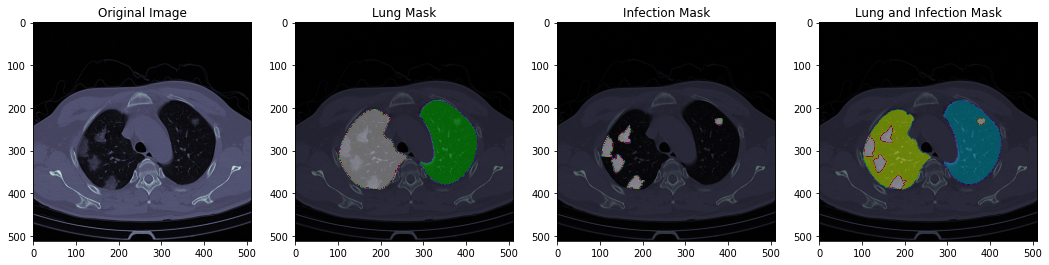

In [ ]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [ ]:
ct = read_nii(data['ct_scan'][0])
print(ct.shape)

(512, 512, 301)


In [ ]:
lungs = []
infections = []
groups = []
img_size = 256
import cv2
from tqdm import tqdm_notebook

total_count = 0
for i in tqdm_notebook(range(len(data))):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    init_count = total_count
    print(ct.shape)
    
    for ii in range(ct.shape[-1]):
        
        if ii==0:
            print(ct[..., ii].shape)
        
        lung_img = cv2.resize(ct[...,ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[...,ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        
#         lung_img = np.array(ct[...,ii])
#         infec_img = np.array(infect[...,ii])
        
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])
        groups.append(i)
        total_count += 1
    
    print(f"patient {i} ranges from {init_count} to {total_count-1}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


(512, 512, 301)
(512, 512)
patient 0 ranges from 0 to 300
(512, 512, 200)
(512, 512)
patient 1 ranges from 301 to 500
(512, 512, 200)
(512, 512)
patient 2 ranges from 501 to 700
(512, 512, 270)
(512, 512)
patient 3 ranges from 701 to 970
(512, 512, 290)
(512, 512)
patient 4 ranges from 971 to 1260
(512, 512, 213)
(512, 512)
patient 5 ranges from 1261 to 1473
(512, 512, 249)
(512, 512)
patient 6 ranges from 1474 to 1722
(512, 512, 301)
(512, 512)
patient 7 ranges from 1723 to 2023
(512, 512, 256)
(512, 512)
patient 8 ranges from 2024 to 2279
(512, 512, 301)
(512, 512)
patient 9 ranges from 2280 to 2580
(630, 630, 39)
(630, 630)
patient 10 ranges from 2581 to 2619
(630, 630, 418)
(630, 630)
patient 11 ranges from 2620 to 3037
(401, 630, 110)
(401, 630)
patient 12 ranges from 3038 to 3147
(630, 630, 66)
(630, 630)
patient 13 ranges from 3148 to 3213
(630, 630, 42)
(630, 630)
patient 14 ranges from 3214 to 3255
(630, 630, 42)
(630, 630)
patient 15 ranges from 3256 to 3297
(630, 630, 45)
(6

In [ ]:
lungs = np.array(lungs)
infections = np.array(infections)
groups = np.array(groups)

print(lungs.shape)
print(infections.shape)
print(groups.shape)

(3520, 256, 256, 1)
(3520, 256, 256, 1)
(3520,)


## Graph a sample image

2222


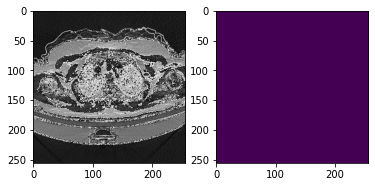

In [ ]:
import random
index = random.randint(0, len(lungs)-1)
print(index) # 10971 is a good one, 9564 is better
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

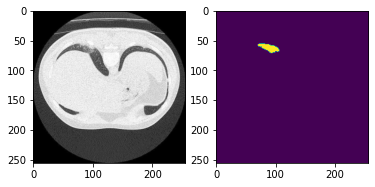

In [ ]:
index = 2700
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

# Split Data

In [ ]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(lungs, infections, groups)
from sklearn.utils import shuffle



train_index, test_index = group_kfold.split(lungs, infections, groups).__next__()
lung_train, lung_test = lungs[train_index], lungs[test_index]
infect_train, infect_test = infections[train_index], infections[test_index]

# # lets also shuffle the data
lung_train, infect_train = shuffle(lung_train, infect_train, random_state=0)
lung_test, infect_test = shuffle(lung_test, infect_test, random_state=0)

print(f"leaving out {np.unique(groups[test_index])}")
    # print(len(train_index))
    # print(len(test_index))


# for train_index, test_index in group_kfold.split(lungs, infections, groups):
#     print(f"leaving out {np.unique(groups[test_index])}")
#     # print(len(train_index))
#     # print(len(test_index))

#     lung_train, lung_test = lungs[train_index], lungs[test_index]
#     infect_train, infect_test = infections[train_index], infections[test_index]

#     # # lets also shuffle the data
#     lung_train, infect_train = shuffle(lung_train, infect_train, random_state=0)
#     lung_test, infect_test = shuffle(lung_test, infect_test, random_state=0)


leaving out [ 2 10 11 16]


2818
(2818, 256, 256, 1)
702
(702, 256, 256, 1)
[[19 49 26 ... 31 35 29]
 [39 17 19 ... 30 23 44]
 [27 14 18 ... 48 43 33]
 ...
 [21 44 46 ... 37 31 20]
 [64 41 39 ... 14 51 46]
 [15 34 60 ... 40 22 40]]
<class 'numpy.ndarray'>
(256, 256)


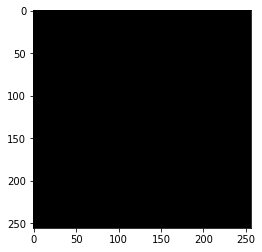

In [ ]:
print(len(infect_train))
print(np.shape(infect_train))
print(len(infect_test))
print(np.shape(infect_test))
plt.imshow(infect_train[150][:, :, 0], cmap='bone')
img = lung_train[150][:,:,0]
img2 = infect_train[150][:,:,0]
print(img)
print(type(img))
print(np.shape(img))
#plt.imsave(('/content/gdrive/My Drive/BME_548_data_new/' + str(150) + '.png'), img, cmap ='bone')

### Just pick the last split to experiment on

# Physical Layer

## Fourier Column Sampling

In [ ]:
def visualize_phyical_layer(top_col):
    global logits_train
    NUM_COLUMNS = 256
    # #visualize the most likely selection

    sum_logits = tf.keras.backend.sum(logits_train.numpy(), axis=0, keepdims=False)

    most_likely = np.argsort(-sum_logits)[:top_col]

    k_space_vec = np.zeros(256)
    k_space_vec[most_likely]=1

    plt.figure(figsize=(10,10))
    plt.imshow(np.stack([k_space_vec]*NUM_COLUMNS, axis=0))
    plt.colorbar()

def visualize_logits():
    global logits_train
    plt.figure(figsize=(10,10))
    plt.imshow(logits_train.value())
    plt.colorbar()

In [ ]:
def reset_physical_layer(trainable=True):
    global logits_train
    NUM_SAMPLES = 128
    NUM_COLUMNS = 256
    if trainable:
        logits_train = tf.Variable(initial_value=tf.ones(shape=(NUM_SAMPLES, NUM_COLUMNS)), dtype='float32' ,trainable=True)
    else:
        logits = np.zeros((NUM_SAMPLES, NUM_COLUMNS))
        logits[:, 1::2] = 1
        logits_train = tf.Variable(initial_value=logits, dtype='float32' ,trainable=False)


Text(0.5, 1.0, 'Post-transform')

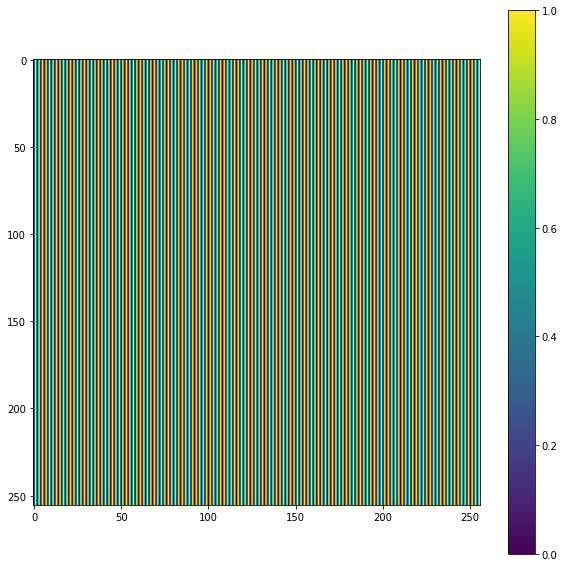

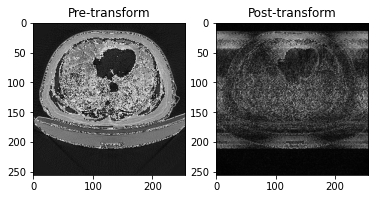

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

reset_physical_layer(False)
visualize_phyical_layer(top_col=128)


def physical_layer(x_batch):
    global logits_train

    x_batch = tf.cast(x_batch[:,:,:,0], dtype=tf.complex64)
    FT_image = tf.signal.fftshift(tf.signal.fft2d(x_batch))

    dist = tfp.distributions.RelaxedOneHotCategorical(temperature=0.3, logits=logits_train)
    sample = dist.sample()
    k_space_vec = tf.keras.backend.sum(sample, axis=0, keepdims=False)

    sampled_four = tf.math.multiply(FT_image, tf.cast(k_space_vec, dtype=tf.complex64), name=None)

    new_image = tf.signal.ifft2d(tf.signal.fftshift(sampled_four))
    new_image = abs(new_image)
    new_image = new_image[...,tf.newaxis]
    return new_image


def physical_layer_saved_weights(x_batch, logits_weight):

    x_batch = tf.cast(x_batch[:,:,:,0], dtype=tf.complex64)
    FT_image = tf.signal.fftshift(tf.signal.fft2d(x_batch))

    dist = tfp.distributions.RelaxedOneHotCategorical(temperature=0.3, logits=logits_weight)
    sample = dist.sample()
    k_space_vec = tf.keras.backend.sum(sample, axis=0, keepdims=False)

    sampled_four = tf.math.multiply(FT_image, tf.cast(k_space_vec, dtype=tf.complex64), name=None)

    new_image = tf.signal.ifft2d(tf.signal.fftshift(sampled_four))
    new_image = abs(new_image)
    new_image = new_image[...,tf.newaxis]
    return new_image

# Make sure it's working
phys_layer_test = physical_layer(lung_train[0:25,:,:,:])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axs[0].imshow(lung_train[4][:,:,0], cmap=plt.cm.gray)
axs[0].set_title("Pre-transform")
axs[1].imshow(phys_layer_test[4][:,:,0], cmap=plt.cm.gray)
axs[1].set_title("Post-transform")

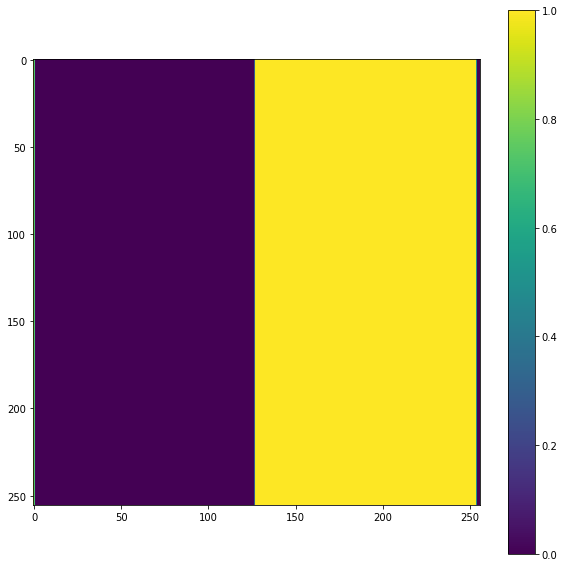

In [ ]:
reset_physical_layer(True)
visualize_phyical_layer(top_col=128)

<bound method BaseResourceVariable.value of <tf.Variable 'Variable:0' shape=(128, 256) dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>>


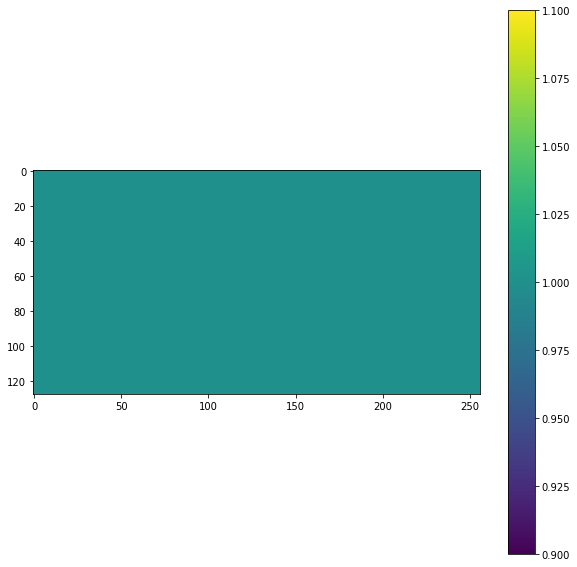

In [ ]:
visualize_logits()
global logits_train
print(logits_train.value)

# U-Net


## Losses

In [ ]:
import numpy as np
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=0.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def loss(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return loss

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
  #print("start")
  intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
  #print("mid")
  union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

  #print("ok")
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss():
  def dice_p_bce(in_gt, in_pred):
    loss = 10.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
    return loss
  return dice_p_bce

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


## Metrics

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def decimal_IOU(y_true, y_pred, smooth=0.001):
    #print("start")
    intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
    #print("mid")
    union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

    return K.mean( (intersection + smooth) / (union + smooth - intersection), axis=0)

In [ ]:
metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]

## U-Net Model Definition

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dropout
import tensorflow as tf

def create_Unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    # down path
    start_filters = 32
    skip_list=[]

    skips=4

    for i in range(skips):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        skip_list.append(x)
        x = MaxPool2D()(x)
        x = Dropout(0.5)(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),skips, padding='same', activation='relu')(x) #7th
    x = Conv2D(start_filters*(2**3),skips, padding='same', activation='relu')(x)
    # up path
    for i in range(skips):
        x = UpSampling2D()(x)
        x = tf.concat([skip_list[-(i+1)], x], axis=-1)
        x = Dropout(0.5)(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    # output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model


In [ ]:
unet_model = create_Unet([256, 256, 1], 1)
unet_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_216 (Conv2D)             (None, 256, 256, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_217 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_216[0][0]                 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_217[0][0]                 
_______________________________________________________________________________________

## U-Net Iterative Learning

In [ ]:
optimize_physical_layer = False #@param {type:"boolean"}


train_ds = tf.data.Dataset.from_tensor_slices((lung_train, infect_train)).shuffle(10000).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((lung_test, infect_test)).batch(16)


global logits_train


reset_layer = True #@param {type:"boolean"}
if reset_layer:
    reset_physical_layer(optimize_physical_layer)

reset_model = True #@param {type:"boolean"}
if reset_model:
    unet_model = create_Unet([256, 256, 1], 1)

# Make sure to reset "unet_FT_multiplier" to whatever pre-initialized variable you are testing
def forward_model(x_batch):
  # p_layer_out = physical_layer(x_batch)
  return unet_model(x_batch)


loss_object = dice_loss()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy', threshold=0.5)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy', threshold=0.5)

# train loop
@tf.function
def train_step(images, labels):
  with tf.GradientTape(persistent=True) as tape:
    predictions = forward_model(images)
    loss = loss_object(labels, predictions)

  if optimize_physical_layer:
    training_variables = [logits_train] + unet_model.trainable_variables
  else:
    training_variables = unet_model.trainable_variables
  gradients = tape.gradient(loss, training_variables)
  optimizer.apply_gradients(zip(gradients, training_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = forward_model(images)
  t_loss = loss_object(labels, predictions)
  ## If you add a print statement here, for some reason, only prints at first epoch
  test_loss(t_loss)
  test_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

EPOCHS = 35 # Change back to 25

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    # NEED TO FIGURE OUT HOW TO SHOW RESULTS FOR ALL OF TRAIN_DS
    # NOT JUST LAST ITERATION
    train_dice_coef, train_decimal_iou = train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_dice_coef, test_decimal_iou = test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'loss: {train_loss.result()}, '
    f'dice_coef: {train_dice_coef[0]}, '
    f'decimal_IOU: {train_decimal_iou[0]}, '
    f'accuracy: {train_accuracy.result() * 100}, '
    f'test_loss: {test_loss.result()}, '
    f'test_dice_coef: {test_dice_coef[0]}, '
    f'test_decimal_iou: {test_decimal_iou[0]}, '
    f'test_accuracy: {test_accuracy.result() * 100}'
  )

unet_logits = logits_train.numpy()

Epoch 1, loss: 0.45226266980171204, dice_coef: 0.0024619665928184986, decimal_IOU: 2.4684970867383527e-06, accuracy: 99.24916076660156, test_loss: 0.4008723795413971, test_dice_coef: 0.021351350471377373, test_decimal_iou: 0.010867581702768803, test_accuracy: 99.12947082519531
Epoch 2, loss: 0.3670979142189026, dice_coef: 0.028312619775533676, decimal_IOU: 0.014141608960926533, accuracy: 99.26400756835938, test_loss: 0.3685366213321686, test_dice_coef: 0.018729832023382187, test_decimal_iou: 0.008644802495837212, test_accuracy: 99.12954711914062
Epoch 3, loss: 0.3030637502670288, dice_coef: 0.006381532177329063, decimal_IOU: 0.0019335616379976273, accuracy: 99.26402282714844, test_loss: 0.7834808230400085, test_dice_coef: 0.48426908254623413, test_decimal_iou: 0.00359986606054008, test_accuracy: 99.12954711914062
Epoch 4, loss: 0.36356988549232483, dice_coef: 0.013883102685213089, decimal_IOU: 0.0059082345105707645, accuracy: 99.26404571533203, test_loss: 0.44414693117141724, test_dice

**Visualize Learned Layer**

In [ ]:
# visualize_phyical_layer(top_col=128)

In [ ]:
# phys_layer_test = physical_layer(lung_train[0:25,:,:,:])
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
# axs[0].imshow(lung_train[4][:,:,0], cmap=plt.cm.gray)
# axs[0].set_title("Pre-transform")
# axs[1].imshow(phys_layer_test[4][:,:,0], cmap=plt.cm.gray)
# axs[1].set_title("Post-transform")

# Visualize Test Results

In [ ]:
import random

# Try 118 and 129

# phys_layer_test_unet = physical_layer_saved_weights(lung_test, unet_logits)
# phys_layer_test_hrnet = physical_layer_saved_weights(lung_test, hrnet_logits)


predicted_unet = unet_model.predict(lung_test)
predicted_hrnet = hrnet_model.predict(lung_test)

# to force it to pick a covid examplem leave while loop uncommented
for i in range(0,5):
  fig = plt.figure(figsize = (18,15))
  # number = random.randint(0, len(lung_test))
  number = 14
  while np.sum(infect_test[number][...,0])==0:
      number = random.randint(0, len(lung_test))

  plt.subplot(1,4,1)
  plt.imshow(lung_test[number][...,0], cmap = 'bone')
  plt.title('original lung')

  plt.subplot(1,4,2)
  #plt.imshow(lung_test[number][...,0], cmap = 'bone')
  plt.imshow(infect_test[number][...,0],alpha = 0.5)
  plt.title('original infection mask')

  plt.subplot(1,4,3)
  # plt.imshow(lung_test[number][...,0], cmap = 'bone')
  plt.imshow(predicted_unet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
  plt.title('Unet predicted infection mask')

  #plt.subplot(1,4,4)
  #plt.imshow(lung_test[number][...,0], cmap = 'bone')
  #plt.imshow(predicted_hrnet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
  #plt.title('HRnet predicted infection mask')
  plt.colorbar()

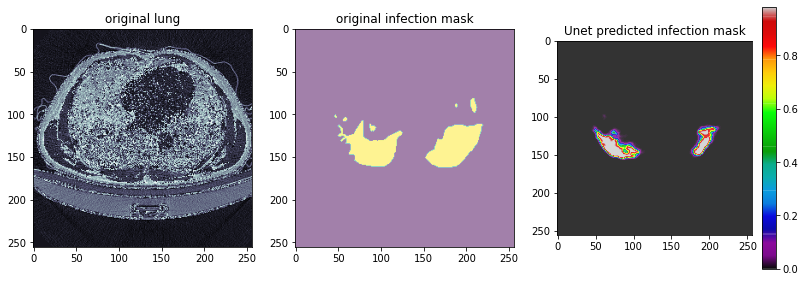

In [ ]:
## To only pick 1...

import random

# phys_layer_test = physical_layer_fixed(lung_test, k_space_vec_unet)


predicted_unet = unet_model.predict(lung_test)
# predicted_hrnet = hrnet_model.predict(phys_layer_test)
fig = plt.figure(figsize = (18,15))



# to force it to pick a covid examplem leave while loop uncommented
number = random.randint(0, len(lung_test))
while np.sum(infect_test[number][...,0])==0:
    number = random.randint(0, len(lung_test))

# number=118
number=129


plt.subplot(1,4,1)
plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,4,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

plt.subplot(1,4,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
a=plt.imshow(predicted_unet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('Unet predicted infection mask')

# plt.subplot(1,4,4)
# #plt.imshow(lung_test[number][...,0], cmap = 'bone')
# plt.imshow(predicted_hrnet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
# plt.title('HRnet predicted infection mask')
plt.colorbar(fraction=0.06, pad=0.05)

# Confusion Matrix Code

In [ ]:
import sklearn
def get_confusion_matrix_elements(groundtruth_image, predicted_image, threshold):

    threshold_image = predicted_image>threshold


    groundtruth_list = groundtruth_image.ravel()
    predicted_list = threshold_image.ravel()


    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
    """
    all_sum = len(groundtruth_list)

    if np.sum(groundtruth_list)==all_sum and np.sum(predicted_list)==all_sum:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif np.sum(groundtruth_list)==0 and np.sum(predicted_list)==0:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp


def batch_confusion_matrix_elements(infection_masks, predicted_masks, threshold):
    results = []

    for i in tqdm_notebook(range(len(predicted_masks))):
        results.append(get_confusion_matrix_elements(infection_masks[i], predicted_masks[i], threshold))
    
    return np.sum(results, axis=0)


def report_classification_results(tn, fp, fn, tp):
    recall_covid = recall_value(tn, fp, fn, tp)
    precision_covid = precision_value(tn, fp, fn, tp)
    f1_score_covid = 1/(1/recall_covid + 1/precision_covid)

    recall_healthy = recall_value(tp, fn, fp, tn) # swap what the positive class is
    precision_healthy = precision_value(tp, fn, fp, tn)
    f1_score_healthy = 1/(1/recall_healthy + 1/precision_healthy)

    IOU_score = iou_value(tn, fp, fn, tp)
    dice_score = dice_value(tn, fp, fn, tp)


    print("Classification Report")
    print("--------------------------------")
    print(f"Covid Recall: {recall_covid*100}%")
    print(f"Covid Precision: {precision_covid*100}%")
    print(f"Covid F1: {f1_score_covid*100}%")
    print(f"Healthy Recall: {recall_healthy*100}%")
    print(f"Healthy Recall: {precision_healthy*100}%")
    print(f"Healthy F1: {f1_score_healthy*100}%")
    print("Segmentation metrics")
    print("---------------------------------")
    print(f"IOU value: {IOU_score}")
    print(f"Dice Score: {dice_score}")
    print("---------------------------------")



def confusion_matrix_plot_hacky(tn, fp, fn, tp):
    fake_label=np.zeros(int(tn))
    fake_predict = np.zeros(int(tn))

    fake_label = np.append(fake_label, np.zeros(int(fp)))
    fake_predict = np.append(fake_predict, np.ones(int(fp)))

    fake_label = np.append(fake_label, np.ones(int(fn)))
    fake_predict = np.append(fake_predict, np.zeros(int(fn)))

    fake_label = np.append(fake_label, np.ones(int(tp)))
    fake_predict = np.append(fake_predict, np.ones(int(tp)))

    print("Printing Classification Report")

    from sklearn.metrics import classification_report, confusion_matrix
    target_names = ['No Covid', 'Covid']
    report_classification_results(tn, fp, fn, tp)


    print("Printing Confusion Matrix")

    import seaborn as sns

    cm = confusion_matrix(fake_label, fake_predict)

    print(cm)
    ax= plt.subplot(1,1,1)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['No Covid', 'Infected']); ax.yaxis.set_ticklabels(['No Covid', 'Infected']);


def iou_value(tn, fp, fn, tp):
    # IOU = true_positive / (true_positive + false_positive + false_negative)
    return tp / (tp + fp + fn)

def dice_value(tn, fp, fn, tp):
    # IOU = 2*true_positive / (2*true_positive + false_positive + false_negative)
    return 2*tp / (2*tp + fp + fn)

def precision_value(tn, fp, fn, tp):
    return tp / (tp + fp)

def recall_value(tn, fp, fn, tp):
    return tp / (tp + fn)


def plot_iou_chart(infection_masks, predicted_masks, thresholds):
    results = []
    precisions = []
    recalls = []
    for thresh in thresholds:
        tn, fp, fn, tp = batch_confusion_matrix_elements(infection_masks, predicted_masks, thresh)
        results.append(iou_value(tn, fp, fn, tp))
        precisions.append(precision_value(tn, fp, fn, tp))
        recalls.append(recall_value(tn, fp, fn, tp))
    
    plt.plot(thresholds, results)
    plt.xlabel("Threshold")
    plt.ylabel("IOU Value")
    plt.show()
    
    print("The results are as follows")
    print(f"IOU: {results}")
    print(f"Precision: {precisions}")
    print(f"Recall: {recalls}")
    print(f"Thresholds: {thresholds}")


In [ ]:
# phys_layer_test_unet = physical_layer_saved_weights(lung_test, unet_logits)
# phys_layer_test_hrnet = physical_layer_saved_weights(lung_test, hrnet_logits)

predicted_unet = unet_model.predict(lung_test)
predicted_hrnet = hrnet_model.predict(lung_test)
fig = plt.figure(figsize = (18,12))


# force it to pick a covid example
number = random.randint(0, len(lung_test))
while np.sum(infect_test[number][...,0])==0:
    number = random.randint(0, len(lung_test))

plt.subplot(1,4,1)
plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,4,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

plt.subplot(1,4,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(predicted_unet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('Unet predicted infection mask')

#plt.subplot(1,4,4)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
#plt.imshow(predicted_hrnet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
#plt.title('HRnet predicted infection mask')
plt.colorbar()

print(get_confusion_matrix_elements(infect_test[number], predicted_unet[number], threshold = 0.5))
print(get_confusion_matrix_elements(infect_test[number], predicted_hrnet[number], threshold = 0.5))

## Make sure to change the Threshold value to see how it changes the results


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Printing Classification Report
Classification Report
--------------------------------
Covid Recall: 36.99005391313468%
Covid Precision: 53.340775283124174%
Covid F1: 21.84279908694652%
Healthy Recall: 99.71588051724898%
Healthy Recall: 99.44820269570222%
Healthy F1: 49.790930863055074%
Segmentation metrics
---------------------------------
IOU value: 0.27947263760438007
Dice Score: 0.4368559817389304
---------------------------------
Printing Confusion Matrix
[[45476238   129575]
 [  252329   148130]]


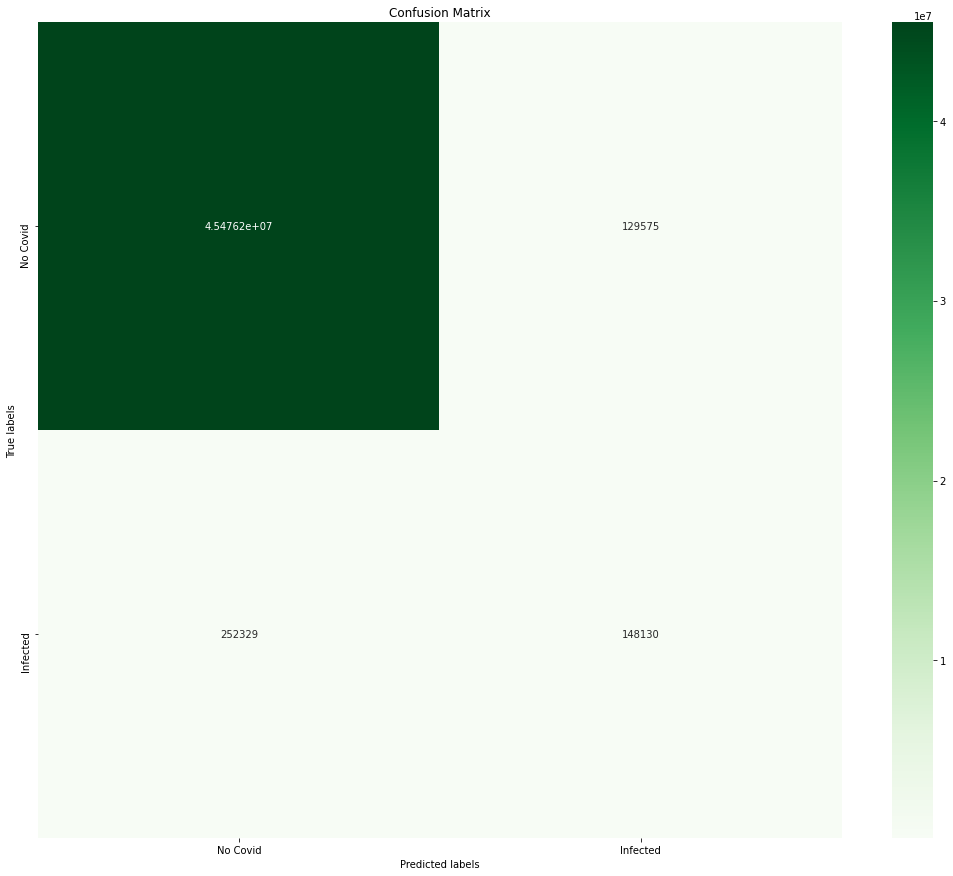

In [ ]:
tn_u, fp_u, fn_u, tp_u = batch_confusion_matrix_elements(infect_test, predicted_unet, threshold=0.2)
#tn_hr, fp_hr, fn_hr, tp_hr = batch_confusion_matrix_elements(infect_test, predicted_hrnet, threshold=0.2)

fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
confusion_matrix_plot_hacky(tn_u, fp_u, fn_u, tp_u)

## IOU Graphs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


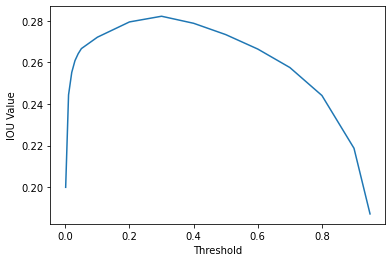

The results are as follows
IOU: [0.19993364211201947, 0.24439696393768082, 0.25522327355120855, 0.2608474778866842, 0.264181028734014, 0.26664006396878615, 0.27213023725391217, 0.27947263760438007, 0.28220239165526867, 0.2788117905452224, 0.27338034737996736, 0.26642313911012633, 0.2575415503621404, 0.24408804899191333, 0.2187178436678227, 0.18714778143063845]
Precision: [0.2310694747090732, 0.3217354581673307, 0.3556215994807925, 0.3774943677228302, 0.3938642092867574, 0.40746849964136433, 0.45484126805561803, 0.5334077528312418, 0.5964371418567512, 0.6366351824327564, 0.6689191331086151, 0.7043808674950304, 0.7480096437891613, 0.7914346538178898, 0.8258355218189013, 0.8513846153846154]
Recall: [0.5973869984193139, 0.504143994766006, 0.474797669674049, 0.4577472350477827, 0.4451691683792848, 0.43550276058223186, 0.40385407744613055, 0.3699005391313468, 0.34880474655333005, 0.33157701537485734, 0.31615970673651983, 0.29996329212228967, 0.2820088947932248, 0.2608681537935219, 0.22929438

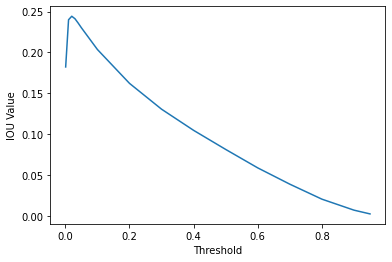

The results are as follows
IOU: [0.1822481994414258, 0.23995896249515006, 0.24424567162633976, 0.2411940898510618, 0.23589994082117663, 0.23018808607091845, 0.20358205031998491, 0.16219308061097312, 0.13060411876695854, 0.10471759967529426, 0.08140245610019213, 0.058836111520873285, 0.038914849171855975, 0.0206117335602515, 0.007172509455238551, 0.002578825174126869]
Precision: [0.21370225605685866, 0.3646658716487788, 0.42434351756228317, 0.46160715512385453, 0.48783955989308136, 0.5080915991295856, 0.5739780062156347, 0.6451043890436733, 0.6939678887610664, 0.7325604838709677, 0.7663457129756992, 0.7921024758374156, 0.8146632124352332, 0.8512124948623099, 0.8840713407134071, 0.902972027972028]
Recall: [0.5532151855745532, 0.4123468320102682, 0.36527584596675317, 0.3356048933848409, 0.31355519541326327, 0.29619761323880844, 0.23981980677172943, 0.17808314958585023, 0.1385859725964456, 0.10888006013099968, 0.08347421334019213, 0.059758926631690135, 0.03926244634282161, 0.02068626251376

In [ ]:
plot_iou_chart(infect_test, predicted_unet, thresholds=[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
# Second plot is from a previous iteration, not used in our final results